In [18]:
# Import libraries!
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

## Model

In [19]:
# Helper for time-regulated production
def pulse_input(t, t_on, t_off, rate):
    if t_on <= t <= t_off:
        return rate
    else:
        return 0.0

# ODE model (dynamic L and R2)
def model(states, t,
          L_on, L_off, L_rate,
          R2_on, R2_off, R2_rate,
          k_a, k_b,       # R1 + L <-> R1L
          k_c, k_d,       # pr_a + R1 <-> pr_R1
          k_e, k_f,       # pr_a + R2 <-> pr_R2
          k_deg1,         # G degradation
          k_deg2,         # R2 degradation
          k_deg3,         # R1 and R1L degradation
          k_syn):         # G synthesis from pr_a
    """
    states = [R1, pr_a, pr_R1, pr_R2, R1L, G, L, R2]
    """

    R1, pr_a, pr_R1, pr_R2, R1L, G, L, R2 = states

    # Time-regulated production rates
    u_L  = pulse_input(t,  L_on,  L_off,  L_rate)
    u_R2 = pulse_input(t, R2_on, R2_off, R2_rate)

    # R1 dynamics: binds L, binds promoter, degrades
    R1_prime = (
        - k_a * R1 * L      # bind L -> R1L
        + k_b * R1L         # unbind L
        + k_deg3 * R1L       # degrade R1L to free R1
        - k_c * pr_a * R1   # bind promoter
        + k_d * pr_R1       # unbind promoter
    )

    # R1L complex dynamics
    R1L_prime = (
        + k_a * R1 * L      # form complex
        - k_b * R1L         # dissociate
        - k_deg3 * R1L      # degrade complex
    )

    # Ligand L dynamics
    L_prime = (
        + u_L               # time-regulated production
        - k_a * R1 * L      # bind R1
        + k_b * R1L         # unbind
        - k_deg3 * L        # degrade free L
        - k_deg3 * R1L      # degrade bound L
    )

    # Promoter states
    pr_a_prime = (
        - k_c * pr_a * R1   # bind R1
        + k_d * pr_R1       # unbind R1
        - k_e * pr_a * R2   # bind R2
        + k_f * pr_R2       # unbind R2
    )

    pr_R1_prime = (
        + k_c * pr_a * R1   # bind
        - k_d * pr_R1       # unbind
    )

    pr_R2_prime = (
        + k_e * pr_a * R2   # bind
        - k_f * pr_R2       # unbind
    )

    # R2 dynamics (real species now)
    R2_prime = (
        + u_R2              # time-regulated production
        - k_e * pr_a * R2   # bind promoter
        + k_f * pr_R2       # unbind promoter
        - k_deg2 * R2       # degrade free R2
    )

    # Gene product G
    G_prime = k_syn * pr_a - k_deg1 * G

    return [R1_prime, pr_a_prime, pr_R1_prime, pr_R2_prime,
            R1L_prime, G_prime, L_prime, R2_prime]


## Figure 2 — Time Series

In [20]:
# ---------- initial conditions ----------
R1_0    = 5.0
pr_a_0  = 0.1   # active promoter
pr_R1_0 = 0.0
pr_R2_0 = 0.0
R1L_0   = 0.0
G_0     = 0.0
L_0     = 0.0
R2_0    = 0.0

states0 = [R1_0, pr_a_0, pr_R1_0, pr_R2_0, R1L_0, G_0, L_0, R2_0]

# ---------- parameters ----------
k_a = 0.05
k_b = 0.10
k_c = 0.70
k_d = 0.30
k_e = 0.50
k_f = 0.30
k_deg1 = 0.02   # G degradation
k_deg2 = 0.05   # R2 degradation
k_deg3 = 0.02   # R1 / R1L / L degradation
k_syn  = 0.50   # G synthesis from pr_a

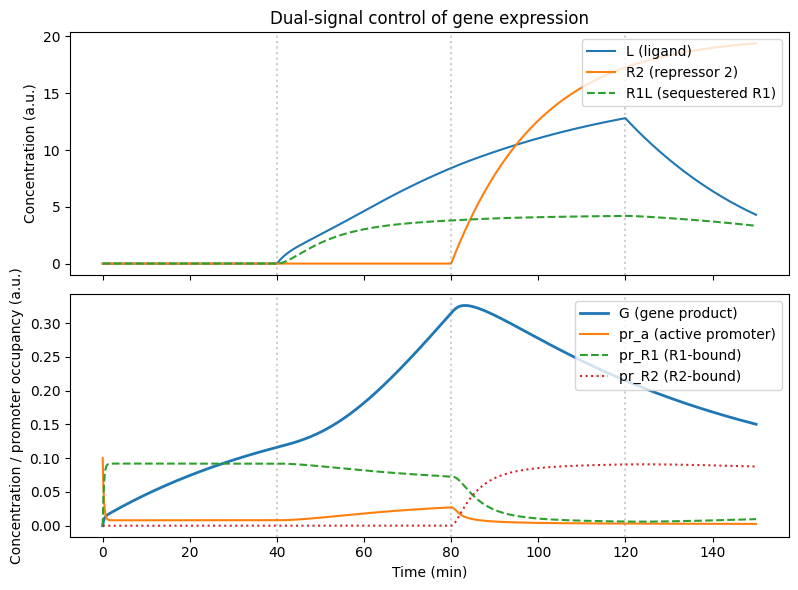

In [ ]:
# =========================
# Figure 2: Time-resolved response to sequential ligand and repressor pulses
# =========================

# ---------- input pulses for 4 phases ----------
# Phase 1:  0–40   L OFF, R2 OFF
# Phase 2: 40–80   L ON,  R2 OFF
# Phase 3: 80–120  L ON,  R2 ON
# Phase 4: 120–150 L OFF, R2 ON

L_on_time   = 40.0
L_off_time  = 120.0
L_prod_rate = 0.5

R2_on_time   = 80.0
R2_off_time  = 150.0
R2_prod_rate = 1.0

# time grid
t_final = np.linspace(0, 150, 1001)

# ---------- simulate ----------
solution = odeint(
    model, states0, t_final,
    args=(L_on_time, L_off_time, L_prod_rate,
          R2_on_time, R2_off_time, R2_prod_rate,
          k_a, k_b,
          k_c, k_d,
          k_e, k_f,
          k_deg1, k_deg2, k_deg3,
          k_syn)
)

# unpack solution
R1    = solution[:, 0]
pr_a  = solution[:, 1]
pr_R1 = solution[:, 2]
pr_R2 = solution[:, 3]
R1L   = solution[:, 4]
G     = solution[:, 5]
L     = solution[:, 6]
R2    = solution[:, 7]

# ---------- Figure 2: stacked time-series ----------
fig, (ax_top, ax_bottom) = plt.subplots(
    2, 1, sharex=True, figsize=(8, 6)
)

# ---- top panel: inputs / upstream species ----
ax_top.plot(t_final, L,  label="L (ligand)")
ax_top.plot(t_final, R2, label="R2 (repressor 2)")
ax_top.plot(t_final, R1L, linestyle="--", label="R1L (sequestered R1)")

ax_top.set_ylabel("Concentration (a.u.)")
ax_top.set_title("Dual-signal control of gene expression")
ax_top.legend(loc="upper right")

# ---- bottom panel: promoter states + output ----
ax_bottom.plot(t_final, G,    linewidth=2, label="G (gene product)")
ax_bottom.plot(t_final, pr_a,           label="pr_a (active promoter)")
ax_bottom.plot(t_final, pr_R1, linestyle="--", label="pr_R1 (R1-bound)")
ax_bottom.plot(t_final, pr_R2, linestyle=":",  label="pr_R2 (R2-bound)")

ax_bottom.set_xlabel("Time (min)")
ax_bottom.set_ylabel("Concentration / promoter occupancy (a.u.)")
ax_bottom.legend(loc="upper right")

# optional: vertical lines to mark phase transitions
for ax in (ax_top, ax_bottom):
    for x in [40, 80, 120]:
        ax.axvline(x, color="gray", linestyle=":", alpha=0.4)

plt.tight_layout()
plt.show()


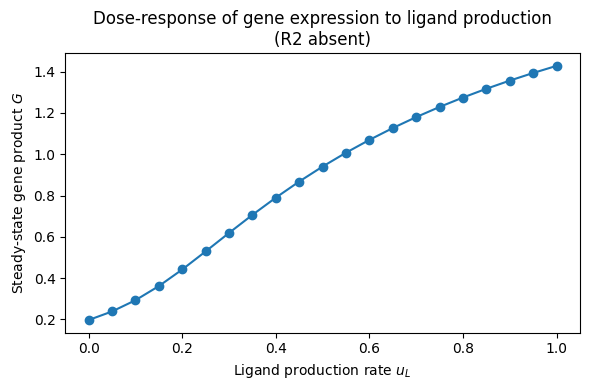

In [23]:
# =========================
# Figure 3: Dose-response of G to ligand production rate
# =========================

# helper: run model for a given L production rate with R2 absent
def run_model_L_rate(L_rate,
                     t_end=200, n_points=1201):
    """
    Simulate the system with a constant ligand production rate L_rate
    and no R2 present.
    """
    t = np.linspace(0, t_end, n_points)

    # R2 is absent: no production
    R2_on_time  = 0.0
    R2_off_time = 0.0
    R2_prod_rate = 0.0

    # L is produced the entire simulation at rate L_rate
    L_on_time  = 0.0
    L_off_time = t_end
    L_prod_rate = L_rate

    sol = odeint(
        model, states0, t,
        args=(L_on_time, L_off_time, L_prod_rate,
              R2_on_time, R2_off_time, R2_prod_rate,
              k_a, k_b,
              k_c, k_d,
              k_e, k_f,
              k_deg1, k_deg2, k_deg3,
              k_syn)
    )
    return t, sol

# sweep over ligand production rates
L_rates = np.linspace(0.0, 1.0, 21)   # adjust max if you want a wider range
G_ss = []

for L_rate in L_rates:
    t, sol = run_model_L_rate(L_rate)
    G_trace = sol[:, 5]  # column 5 is G
    # use mean of last 50 time points as "steady-state" G
    G_ss.append(G_trace[-50:].mean())

# make dose-response plot
plt.figure(figsize=(6, 4))
plt.plot(L_rates, G_ss, marker="o")
plt.xlabel("Ligand production rate $u_L$")
plt.ylabel("Steady-state gene product $G$")
plt.title("Dose-response of gene expression to ligand production\n(R2 absent)")
plt.tight_layout()
plt.show()
